In [1]:
# Packages to import.
# !pip install transformers
#!pip install torchvision
#!pip install diffusers
!pip install dataclasses

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 259.87it/s]
INFO:root:Length of dataset is 833.
INFO:root: First element in dataset is {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1280 at 0x308C80670>, 'text': 'a drawing of a green pokemon with red eyes'}.


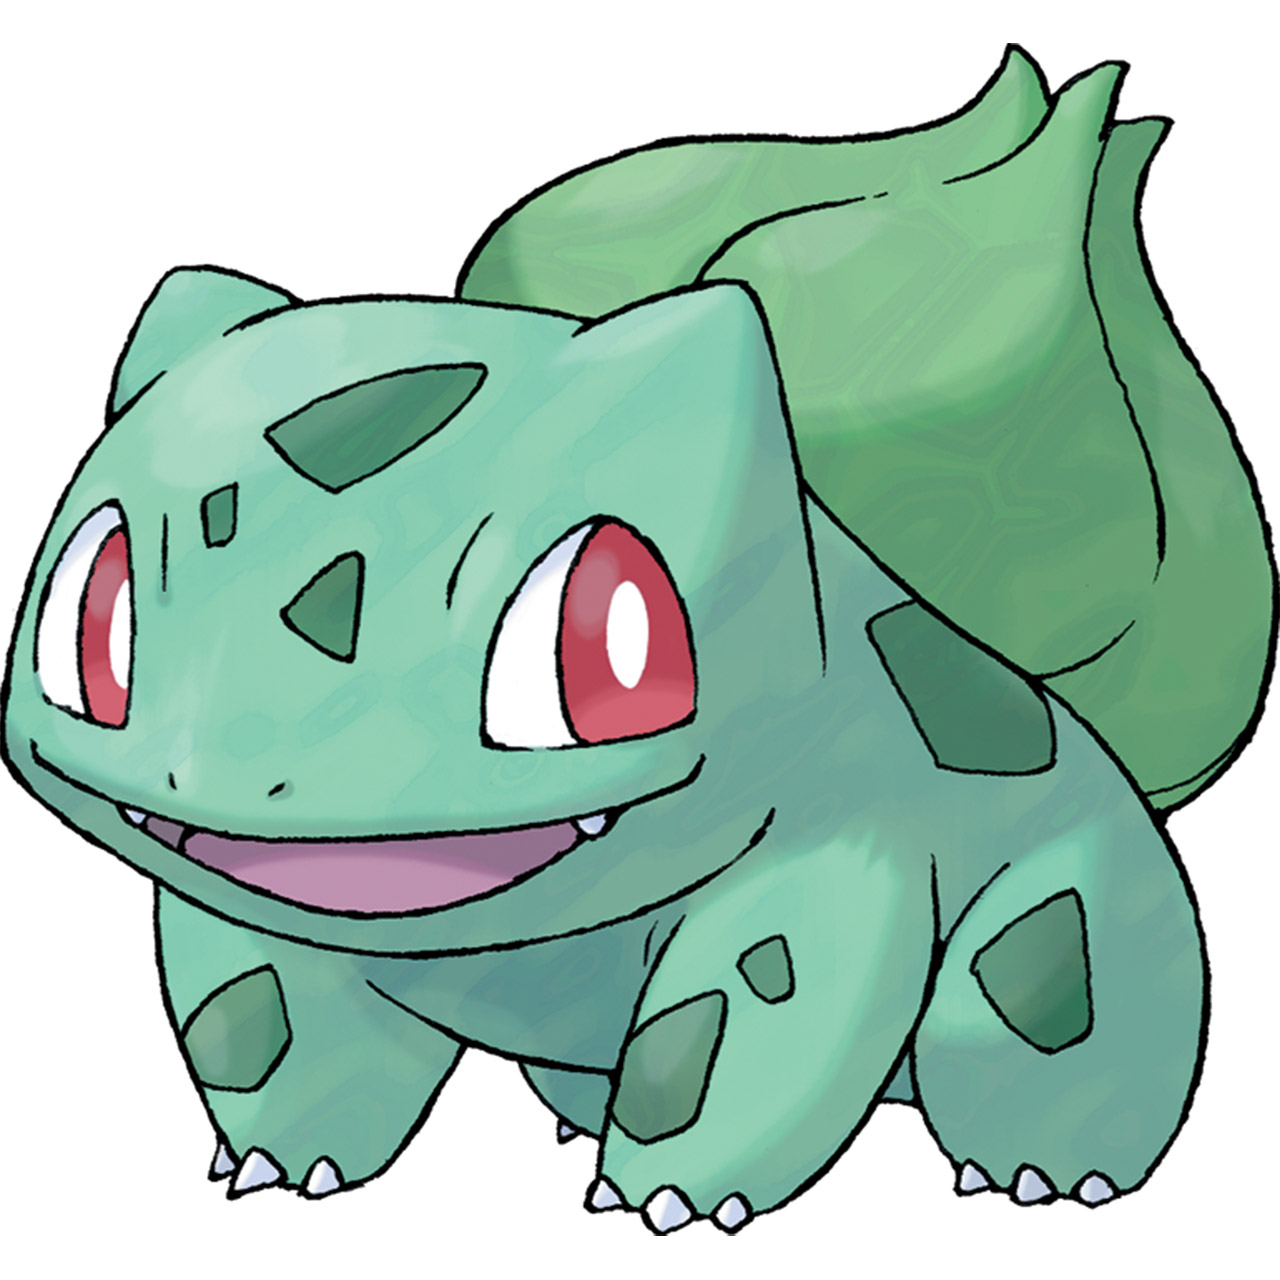

INFO:root:Caption is a drawing of a green pokemon with red eyes.
INFO:root:Length of dataset is 833.
INFO:root: First element in dataset is {'image': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), 'text': {'input_ids': [49406, 320, 3610, 539, 320, 1901, 9528, 

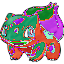

INFO:root:Caption is <|startoftext|>a drawing of a green pokemon with red eyes <|endoftext|>.
INFO:root:Epoch index : 0. Batch index: 0. Loss: 0.7236933708190918.


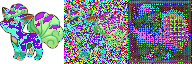

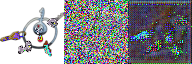

INFO:root:Epoch index : 0. Batch index: 20. Loss: 0.06275465339422226.


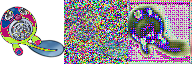

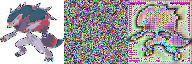

INFO:root:Epoch index : 1. Batch index: 0. Loss: 0.05701487883925438.


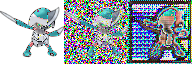

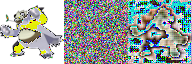

INFO:root:Epoch index : 1. Batch index: 20. Loss: 0.05100307986140251.


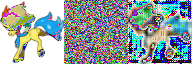

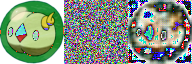

INFO:root:Epoch index : 2. Batch index: 0. Loss: 0.056695517152547836.


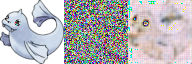

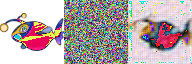

INFO:root:Epoch index : 2. Batch index: 20. Loss: 0.04280279204249382.


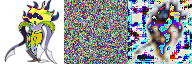

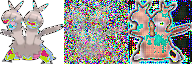

INFO:root:Epoch index : 3. Batch index: 0. Loss: 0.044085025787353516.


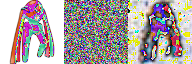

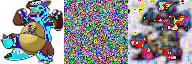

INFO:root:Epoch index : 3. Batch index: 20. Loss: 0.033104345202445984.


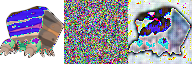

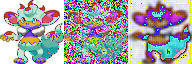

INFO:root:Epoch index : 4. Batch index: 0. Loss: 0.030385687947273254.


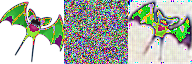

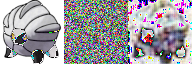

INFO:root:Epoch index : 4. Batch index: 20. Loss: 0.02789093181490898.


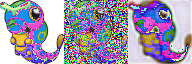

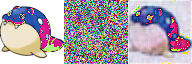

INFO:root:Epoch index : 5. Batch index: 0. Loss: 0.03656170889735222.


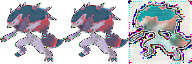

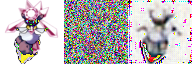

INFO:root:Epoch index : 5. Batch index: 20. Loss: 0.028558343648910522.


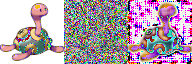

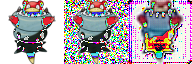

INFO:root:Epoch index : 6. Batch index: 0. Loss: 0.026740916073322296.


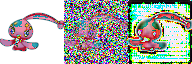

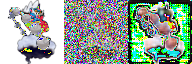

INFO:root:Epoch index : 6. Batch index: 20. Loss: 0.021340815350413322.


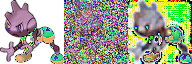

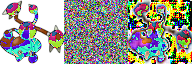

INFO:root:Epoch index : 7. Batch index: 0. Loss: 0.03553847223520279.


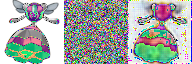

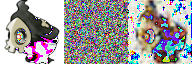

INFO:root:Epoch index : 7. Batch index: 20. Loss: 0.023021619766950607.


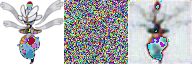

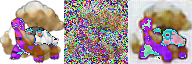

INFO:root:Epoch index : 8. Batch index: 0. Loss: 0.03398491069674492.


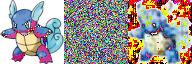

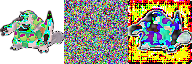

INFO:root:Epoch index : 8. Batch index: 20. Loss: 0.03683146461844444.


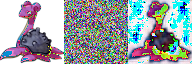

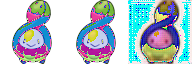

INFO:root:Epoch index : 9. Batch index: 0. Loss: 0.025684107095003128.


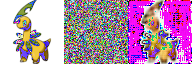

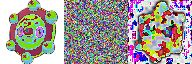

INFO:root:Epoch index : 9. Batch index: 20. Loss: 0.022369710728526115.


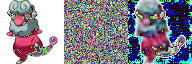

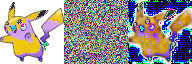

In [14]:
from PIL import Image
from IPython.display import display
from datasets import load_dataset
from torchvision import transforms
import torch
from transformers import CLIPTokenizer, tokenization_utils_base
from typing import Union, Optional, Any
from functools import partial
from diffusers import AutoencoderKL
from dataclasses import dataclass
from torch import nn
import math
import logging

logging.getLogger().setLevel(logging.INFO)

# Verify columns.
def verify_columns(dataset, image_column: str, caption_column: str) -> None:
    dataset_columns = dataset.column_names
    assert image_column_name in dataset_columns, f'{image_column_name} not in {dataset_columns}.'
    assert caption_column_name in dataset_columns, f'{caption_column_name} not in {dataset_columns}.'


# Visualize dataset.
def visualize_dataset(dataset, image_column_name: str, caption_column_name: str, visualize: bool = True) -> None:
    if visualize:
        logging.info(f'Length of dataset is {len(dataset)}.')
        assert len(dataset) > 0, 'Dataset is empty.'
        first_element = dataset[0]
        logging.info(f' First element in dataset is {first_element}.')
        image = first_element[image_column_name]
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        display(image)
        caption = first_element[caption_column_name]
        if isinstance(caption, tokenization_utils_base.BatchEncoding):
            caption = tokenizer.decode(caption["input_ids"])
        logging.info(f'Caption is {caption}.')
        
# Function to map dataset elements to tensors.
def preprocess_dataset(dataset, image_size, image_column_name, caption_column_name, image_key, text_key, tokenizer):
    transforms_list = transforms.Compose([
            transforms.Resize((image_size, image_size)), 
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])])
    preprocessed_images = [transforms_list(i) for i in dataset[image_column_name]]
    tokenized_text = [tokenizer(t) for t in dataset[caption_column_name]]
    return {image_key: preprocessed_images, text_key: tokenized_text}

def collate_fn(data: list[Any], tokenizer, image_column_name, text_column_name) -> dict[str, torch.Tensor]:
    output = {}
    output[image_column_name] = torch.stack([d[image_column_name] for d in data])
    output[text_column_name] = tokenizer.pad([d[text_column_name] for d in data],
                                             padding=True,
                                             return_tensors='pt')
    return output

def visualize_predictions(input_image, input_text, noisy_image, predictions, num_predictions_to_visualize = 2):
    (batch_size, _, _, _) = input_image.shape
    for batch_index in range(min(batch_size, num_predictions_to_visualize)):
        current_tensor = torch.cat([input_image[batch_index], noisy_image[batch_index], predictions[batch_index]], dim = 2)
        display(transforms.ToPILImage()(current_tensor))

class ResidualBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, mid_channels = None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mid_channels = mid_channels if mid_channels else out_channels
        self.layers = nn.Sequential(
                nn.Conv2d(self.in_channels, self.mid_channels, kernel_size, padding = 'same'),
                nn.BatchNorm2d(self.mid_channels),
                nn.ReLU(),
                nn.Conv2d(self.mid_channels, self.out_channels, kernel_size, padding = 'same'),
                nn.BatchNorm2d(self.out_channels))
        self.residual_layer = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, kernel_size = 1)
    def forward(self, x):
        residual = self.residual_layer(x)
        return residual + self.layers(x)
        

class UNetWithCrossAttention(nn.Module):
    def __init__(self, skip_connections:bool = False):
        super().__init__()
        self.skip_connections = skip_connections
        self.encoder_depths = [64, 128, 256, 512]
        self.encoder_strides = [1, 2, 2, 2]
        self.decoder_depths = [512, 256, 128, 64]
        self.decoder_strides = [2, 2, 2, 1]
        self.input_depth = 3
        self.kernel_size = 3
        
        self.initial_image_conv = nn.Conv2d(self.input_depth, self.encoder_depths[0], self.kernel_size, padding = 'same')
        encoder_blocks_list = []
        for i in range(len(self.encoder_depths) - 1):
            encoder_blocks_list.extend([
                ResidualBlock2d(self.encoder_depths[i], self.encoder_depths[i], kernel_size = self.kernel_size),
                ResidualBlock2d(self.encoder_depths[i], self.encoder_depths[i + 1], kernel_size = self.kernel_size),
                nn.MaxPool2d(stride = self.encoder_strides[i + 1], kernel_size = self.kernel_size, padding = 1)
            ])
        self.encoder_blocks = nn.ModuleList(encoder_blocks_list)
        decoder_blocks_list = []
        for i in range(len(self.decoder_depths) - 1):
            skip_connection_multiplier = 2 if i > 0 and self.skip_connections else 1
            decoder_blocks_list.extend([
                ResidualBlock2d(self.decoder_depths[i] * skip_connection_multiplier, self.decoder_depths[i], kernel_size = self.kernel_size),
                ResidualBlock2d(self.decoder_depths[i], self.decoder_depths[i + 1], kernel_size = self.kernel_size),
                nn.ConvTranspose2d(self.decoder_depths[i + 1], self.decoder_depths[i + 1], stride = self.decoder_strides[i], kernel_size = self.kernel_size, padding = 1, output_padding = 1)
            ])
        self.decoder_blocks = nn.ModuleList(decoder_blocks_list)        
        self.final_image_conv = nn.Conv2d(self.decoder_depths[-1], self.input_depth, self.kernel_size, padding = 'same')
        
    def forward(self, input_image, input_text):
        [batch_size, current_input_depth, _, _] = input_image.shape
        assert current_input_depth == self.input_depth, f'Unexpected input depth {current_input_depth}. Expected {self.input_depth}.'
        features = self.initial_image_conv(input_image)
        encoder_features = []
        for (encoder_block_index, encoder_block) in enumerate(self.encoder_blocks):
            features = encoder_block(features)
            if encoder_block_index % 3 == 2:
                encoder_features.append(features)
                
        for (decoder_block_index, decoder_block) in enumerate(self.decoder_blocks):
            if decoder_block_index > 2 and decoder_block_index % 3 == 0:
                features = torch.cat([features, encoder_features[-1 * (decoder_block_index//3) - 1]], dim = 1)
            features = decoder_block(features)
        predictions = self.final_image_conv(features)
        return predictions
    
class NoiseScheduler:
    def __init__(self, max_time_steps, device):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.max_time_steps = max_time_steps
        self.device = device
        
    def beta(self, t):
        return self.beta_small + (t / self.max_time_steps) * (self.beta_large - self.beta_small)

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        return math.prod([self.alpha(j) for j in range(t)])
        
    @torch.no_grad()
    def add_noise(self, input):
        batch_size = input.shape[0]
        time_steps = torch.randint(0, self.max_time_steps, (batch_size,), device=self.device)

        noisy_images = []
        epsilons = torch.randn(input.shape, device = self.device)
        for i in range(len(time_steps)):
            a_hat = self.alpha_bar(time_steps[i])
            noisy_images.append(
                (math.sqrt(a_hat) * input[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noisy_images = torch.stack(noisy_images, dim=0)
        return noisy_images, epsilons
    
    @torch.no_grad()
    def denoise(self, noisy_images, timestep, model, input_text):
        z = torch.randn(noisy_images.shape, device = self.device) if timestep > 1 else 1
        e_hat = model(noisy_images, input_text)
        pre_scale = 1 / math.sqrt(self.alpha(timestep))
        e_scale = (1 - self.alpha(timestep)) / math.sqrt(1 - self.alpha_bar(timestep))
        post_sigma = math.sqrt(self.beta(timestep)) * z
        denoised_images = pre_scale * (noisy_images - e_scale * e_hat) + post_sigma
        return denoised_images

# Hyperparameters
# Dataset hyper parameters.
dataset_name = 'lambdalabs/pokemon-blip-captions'
tokenizer_name = 'CompVis/stable-diffusion-v1-4'
text_encoder_name = 'CompVis/stable-diffusion-v1-4'
image_encoder_name = 'CompVis/stable-diffusion-v1-4'
train_split_name = 'train'
image_column_name = 'image'
caption_column_name = 'text'

# Architecture hyperparamters.
image_size = 64
down_sizes = [256, 128, 64]
up_sizes = [64, 128, 256]

# Training hyper parameters.
batch_size = 4
num_epochs = 10
num_batches = 40
num_batches_to_visualize = 20
max_time_steps = 100

# Setting device.
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        ValueError("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        ValueError("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

device = torch.device('mps')

# Load dataset, verify columns and dataloader.
torch.manual_seed(123)
dataset = load_dataset(dataset_name)
assert train_split_name in dataset.keys(), f'{train_split_name} is not a valid key in the dataset dictionary.'
train_dataset = dataset[train_split_name]
verify_columns(train_dataset, image_column_name, caption_column_name)
visualize_dataset(train_dataset, image_column_name, caption_column_name, True)

tokenizer = CLIPTokenizer.from_pretrained(tokenizer_name, subfolder="tokenizer")
preprocess_dataset_partial = partial(preprocess_dataset, image_size = image_size, image_column_name = image_column_name, caption_column_name = caption_column_name, image_key = 'image', text_key = 'text', tokenizer = tokenizer)
train_dataset.set_transform(preprocess_dataset_partial)
visualize_dataset(train_dataset, image_column_name, caption_column_name, True)

collate_fn_partial = partial(collate_fn, tokenizer = tokenizer, image_column_name = image_column_name, text_column_name = caption_column_name)
train_dataloader = torch.utils.data.DataLoader(dataset['train'], shuffle = True, batch_size = batch_size, collate_fn = collate_fn_partial)

image_encoder = AutoencoderKL.from_pretrained(image_encoder_name, subfolder = "vae")
model = UNetWithCrossAttention(skip_connections = True)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-3)
noise_scheduler = NoiseScheduler(max_time_steps, device)
for epoch_index in range(num_epochs):
    for batch_index, batch in enumerate(train_dataloader):
        logging.debug(f'Sizes of tensors in batch are {batch["image"].shape} and {batch["text"]["input_ids"].shape}.')
        if batch_index >= num_batches:
            break
        input_image = batch['image'].to(device)
        noisy_image, epsilons = noise_scheduler.add_noise(input_image)
        input_text = batch['text'].to(device)
        noise_predictions = model(noisy_image, input_text)
        optimizer.zero_grad()
        loss = nn.MSELoss()(input_image, noise_predictions)
        loss.backward()
        optimizer.step()
        if batch_index % num_batches_to_visualize == 0:
            logging.info(f'Epoch index : {epoch_index}. Batch index: {batch_index}. Loss: {loss}.')
            denoised_image = model(noisy_image, input_text)
            #for time_step in range(max_time_steps, 0, -1):
            #    denoised_image = noise_scheduler.denoise(denoised_image, time_step, model, input_text)
            visualize_predictions(input_image, input_text, noisy_image, denoised_image)

    
